In [1]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
### User-defined - inputs:

### Objective Function:
obj_func = 'Sine'

### Data inputs:
n_test = 100
set_seed = 888 #initialise pseudo-random number generator, same start-point each time.

### Student-t parameter input:
nu = 3 # Degree(s)-of-freedom (DF)

### Acquisition / Utility function - MLE/Type II:
util = 'EI_STP'
util_new = 'ERM_STP'

### Probabilistic / Surrogate / Stochastic model - MLE/Type II: 
surrogate_model_stp = 'Student-t Process'

### Covariance Function:
cov_func = squaredExponential()

n_init = 2  # Number of iterations used to initialise Bayesian optimisation; minimum 2


In [3]:
### Objective Function - Sin(x) 1-D:

if obj_func == 'Sine':

    def f_syn_polarity(x1_training):
        return operator * np.sin(x1_training)
        
# Constraints:
    lb = 0
    ub = 2 * np.pi
    
# Input array dimension(s):
    dim = 1

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub])}
    
# True y bounds:
    y_lb = 1 # targets global maximum 
    operator = 1 # targets global maximum 
    y_global_orig = y_lb * operator # targets global maximum
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
            

In [4]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [9]:
### Acquisition function derivatives:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI_STP': self.EI_STP,
            'ERM_STP': self.ERM_STP
        }

        self.f = mode_dict[mode]
        
    
    def EI_STP(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - tau - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    
    def ERM_STP(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu, **self.params)


In [17]:
### Set iterations:

max_iter = 0

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911


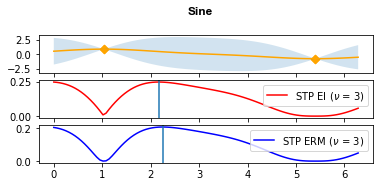

In [20]:
### Acquisition plots - Student's-t dERM vs dEI:

def plot_STPGO(stpgo, param, index, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = stpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 3.182 * std, y_hat + 3.182 * std #t-score, 3 DF, 95% confidence (two-tail)
    if new:
        plt.figure()
        plt.subplot(5, 1, 1)
        plt.scatter(stpgo.GP.X, stpgo.GP.y, marker ='D', color = 'Orange')
        plt.scatter(stpgo.X, stpgo.y, marker ='D', color = 'Orange')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2)
        plt.plot(x_test.flatten(), y_hat, color = 'Orange')
    plt.subplot(5, 1, index)
    a = np.array([-stpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a, color=colors[index - 2], label=acq_titles[index - 2])
    stpgo._optimizeAcq(method='L-BFGS-B', n_start=1000)
    plt.axvline(x=stpgo.best)
    plt.legend(loc=0)

acq_1 = Acquisition_new(util)
acq_2 = Acquisition_new(util_new)
acq_list = [acq_1, acq_2]
param = {'x1_training': ('cont', [0, 2 * np.pi])}

new = True
colors = ['red', 'blue']
acq_titles = ['STP EI ' r'($\nu$' ' = {})'.format(nu), 'STP ERM ' r'($\nu$' ' = {})'.format(nu)]

for index, acq in enumerate(acq_list):
    np.random.seed(set_seed)
    stp = tStudentProcess(cov_func, nu = nu)
    stpgo = GPGO(stp, acq, f_syn_polarity, param)
    stpgo.run(init_evals=n_init, max_iter=max_iter)
    plot_STPGO(stpgo, param, index=index+2, new=new)
    new = False
    
title = obj_func
plt.suptitle(title, weight = 'bold', family = 'arial')    
plt.show()